In [3]:
from scripts import support, metrics, vectorization as v, aggregation
from scripts.kuroda import kuroda
from scripts.insd import insd
from scripts.nras import nras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
%matplotlib inline

## Prepaire data

In [42]:
#CODES


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "NAICS Codes", skiprows=4)
df = df.iloc[:-6,:-1]
df = df.dropna(axis=0, how = 'all')
df = df.fillna(0)

codes = np.array(df)

In [43]:
#DET 2007


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2007")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2007 = np.array(df)
DET_2007 = np.where(DET_2007=='...', 0, DET_2007)
dt_2007 = v.tovector(DET_2007).astype(float)
# np.shape(DET_2007)

In [44]:
#DET 2012


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2012")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2012 = np.array(df)
DET_2012 = np.where(DET_2012=='...', 0, DET_2012)
dt_2012 = v.tovector(DET_2012).astype(float)


#Зануляем элементы, в которых меняется знак
det_2007 = dt_2007
det_2012 = dt_2012
det_2007[dt_2007 * dt_2012 < 0] = 0
det_2012[dt_2007 * dt_2012 < 0] = 0
DET_2012[DET_2007 * DET_2012 < 0] = 0


#Считаем итоги по строкам и столбцам
rows_sums_2012 = np.sum(DET_2012, axis=1)
columns_sums_2012 = np.sum(DET_2012, axis=0)
totals_2012 = np.concatenate((rows_sums_2012, columns_sums_2012)).astype(float)[np.newaxis].T
# DET_2012

In [45]:
#SUM 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2007")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2007 = np.array(df)
SUM_2007 = np.where(SUM_2007=='...', 0, SUM_2007)

SUM_2007[[72, 71]] = SUM_2007[[71, 72]]
sum_2007 = v.tovector(SUM_2007).astype(float)

#Считаем итоги по строкам и столбцам
rows_sums_2007 = np.sum(DET_2007, axis=1)
columns_sums_2007 = np.sum(DET_2007, axis=0)
totals_2007 = np.concatenate((rows_sums_2007, columns_sums_2007)).astype(float)[np.newaxis].T
# np.shape(SUM_2007)

In [46]:
#SUM 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2012")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2012 = np.array(df)
SUM_2012 = np.where(SUM_2012=='...', 0, SUM_2012)

SUM_2012[[72, 71]] = SUM_2012[[71, 72]]
sum_2012 = v.tovector(SUM_2012).astype(float)
# SUM_2012

In [47]:
#SECT 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2007")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2007 = np.array(df)
SECT_2007 = np.where(SECT_2007=='...', 0, SECT_2007)
sect_2007 = v.tovector(SECT_2007).astype(float)
# SECT_2007

In [48]:
#SECT 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2012")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2012 = np.array(df)
SECT_2012 = np.where(SECT_2012=='...', 0, SECT_2012)
sect_2012 = v.tovector(SECT_2012).astype(float)
# SECT_2012

In [49]:
#parsing aggregation codes


sect_rows, sect_columns, sum_rows, sum_columns = aggregation.parse_agg(codes)

In [50]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SUM (73,71)

left_sum = aggregation.make_keym(405, 73, sum_rows)
right_sum = aggregation.make_keym(405, 71, sum_columns)

g_to_sum = csr_matrix(aggregation.keys_to_g(left_sum, right_sum))

In [52]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SECT (17,15)

left_sect = aggregation.make_keym(405, 17, sect_rows)
right_sect = aggregation.make_keym(405, 15, sect_columns)

g_to_sect = csr_matrix(aggregation.keys_to_g(left_sect, right_sect))

In [53]:
true_sum_2012 = g_to_sum @ det_2012

In [54]:
true_sect_2012 = g_to_sect @ det_2012

In [59]:
# Add totals to aggregation
sum_2012_with_totals = np.append(sum_2012, totals_2012, axis=0)
true_sum_2012_with_totals = np.append(true_sum_2012, totals_2012, axis=0)


g_sum_w_totals = v.addrows((405,405), g_to_sum, sparsed=True)
g_sum_w_totals = v.addcolumns((405,405), g_sum_w_totals, sparsed=True)

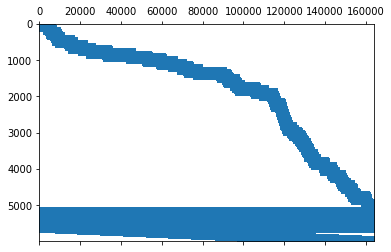

In [60]:
plt.spy(g_sum_w_totals,aspect='auto')

## Let's experiment!

In [61]:
from scripts import support, metrics, vectorization as v, aggregation
def experiment(tables_kind, method_name, bench_matrix, origin_matrix, target_matrix, experiment_type, sparsed = True, save = True, totals = False):
    """
    Получение результата эксперимента

    Parameters
    ----------
    tables_kind: string
        степень аггрегации таблиц
    method_name: string
        метод для получения новой матрицы
    bench_matrix: np.array или sparse матрица
        бенчмарк таблица
    origin_matrix: np.array или sparse матрица
        оригинальная таблица
    target_matrix: np.array или sparse матрица
        целевая таблица
    experiment_type: string
        агрегация\дезаггрегация\проекция
    sparse: bool
        использовать sparse матрицу или np.array
    Returns
    -------
    a: float
        значение метрики
    """
    if experiment_type == 'дезаггрегация':
        if tables_kind == 'sum':
            g = aggregation.keys_to_g(left_sum, right_sum)
        elif tables_kind == 'sect':
            g = aggregation.keys_to_g(left_sect, right_sect)
        else:
            raise Exception("Wrong tables_kind", tables_kind)
    elif experiment_type == 'проекция':
        ttls = v.addrows((405,405))
        g = v.addcolumns((405,405), ttls)
    else:
        raise Exception("Wrong experiment_type",experiment_type)  
    

    if sparsed:
        g = csr_matrix(g)
        
    if totals:
        g_w_totals = v.addrows((405,405), g, sparsed=sparsed)
        g_w_totals = v.addcolumns((405,405), g_w_totals, sparsed=sparsed)
    
    # For Kuroda
    if len(method_name.split('_')) > 1:
        
        method, mtype = method_name.split('_')
        method = eval(method)
        results = np.round(method(g, eval(bench_matrix), eval(origin_matrix), mtype=int(mtype), sparsed=sparsed))
    else:
        method = eval(method_name)
        results = method(g, eval(bench_matrix), eval(origin_matrix), sparsed=sparsed)
    metrics_values = metrics.get_values(np.round(results), eval(target_matrix), save=True)
    
    # Save metrics' results
    if save:
        info = {'method':method_name, 'experiment_type':experiment_type, 'target_matrix':target_matrix, 
                'origin_matrix':origin_matrix, 'bench_matrix':bench_matrix}
        info = {**info,**metrics_values}

        res_table = pd.read_excel('results/results.xlsx')
        res_table = res_table.append([info])
        res_table.to_excel('results/results.xlsx', index=None,encoding='utf-8')

    return metrics_values 

def experiments(tables_kind, bench_matrix, origin_matrix, target_matrix, experiment_type, totals = False):
    methods_list = ['nras','insd','kuroda_3','kuroda_2','kuroda_1']
    sparsed = True
    for i, method in enumerate(methods_list):
        print('Method:', method)
        if i > 2:
            sparsed = False
        experiment(tables_kind, method, bench_matrix, origin_matrix, target_matrix, experiment_type, 
                   sparsed = sparsed, totals = totals)
            

In [ ]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('sum', 'det_2007', 'sum_2012', 'det_2012', 'дезаггрегация')

In [26]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица true_SUM_2012
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('sum', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация')

Method:  nras
1
Method:  insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Para

In [27]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SECT_2012
#Бенчмарк: DET_2007
#Ограничения: таблица true_SECT_2012
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('sect', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация')

Method:  nras
1
Method:  insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Para

In [28]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SECT_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SECT_2012
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('sect', 'det_2007', 'sect_2012', 'det_2012', 'дезаггрегация')

Method:  nras
1
Method:  insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method:  kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Para

In [40]:
#Эксперимент: проекция таблицы DET_2012 из таблицы totals_2012
#Бенчмарк: DET_2007
#Ограничения: таблица totals_2012
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('', 'det_2007', 'totals_2012', 'det_2012', 'проекция')

Method: nras
67
Method: insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Paramete

In [56]:
#Эксперимент: проекция таблицы DET_2007 из таблицы totals_2007
#Бенчмарк: DET_2012
#Ограничения: таблица totals_2007
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('', 'det_2012', 'totals_2007', 'det_2007', 'проекция')

Method: nras
78
Method: insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Paramete

In [64]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: NRAS, точность 0.01, 100 иттераций




result_sum_to_det = np.round(nras(g_sum_w_totals, det_2007, sum_2012_with_totals, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

100
N0 1461
PSISTAT 0.0146
RSQ 0.9909
MAPE 9.9558
SWAD 0.0317
WAPE 13.0282


In [67]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('sum', 'det_2007', 'sum_2012_with_totals', 'det_2012', 'дезаггрегация',totals = True)

Method: nras


ERROR:root:Traceback (most recent call last):
  File "/Users/Aska/GitHub/Disaggregation/scripts/nras.py", line 41, in nras
    while (max(abs(G.dot(a) - c).flatten()) > accuracy) and (counter < limit):
ValueError: operands could not be broadcast together with shapes (5183,1) (5993,1) 

ERROR:root:Traceback (most recent call last):
  File "/Users/Aska/GitHub/Disaggregation/scripts/metrics.py", line 180, in PsiStat
    if x.ndim == 1 or x.shape[1] == 1:
IndexError: tuple index out of range

ERROR:root:Traceback (most recent call last):
  File "/Users/Aska/GitHub/Disaggregation/scripts/metrics.py", line 224, in RSQ
    if x.ndim == 1 or x.shape[1] == 1:
IndexError: tuple index out of range

ERROR:root:Traceback (most recent call last):
  File "/Users/Aska/GitHub/Disaggregation/scripts/metrics.py", line 152, in swad
    if x.ndim == 1 or x.shape[1] == 1:
IndexError: tuple index out of range

ERROR:root:Traceback (most recent call last):
  File "/Users/Aska/GitHub/Disaggregation/scripts/met

Method: insd


KeyboardInterrupt: 

In [15]:
experiment('sum', 'nras', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', True)

1


{'N0': 1481,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'MAPE': 14.9614,
 'SWAD': 0.066,
 'WAPE': 23.2184}

In [16]:
experiment('sum', 'insd', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', True)

Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


{'N0': 1443,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'MAPE': 14.9658,
 'SWAD': 0.066,
 'WAPE': 23.2178}

In [17]:
experiment('sum', 'kuroda_3', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', sparsed = True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1873,
 'PSISTAT': 0.0339,
 'RSQ': 0.9684,
 'MAPE': 15.0596,
 'SWAD': 0.066,
 'WAPE': 23.2343}

In [23]:
experiment('sum', 'kuroda_2', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 14.9874,
 'N0': 1453,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2234}

In [19]:
experiment('sum', 'kuroda_1', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1436,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'MAPE': 14.9839,
 'SWAD': 0.066,
 'WAPE': 23.2231}

In [20]:
experiment('sect', 'nras', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', True)

1


{'N0': 1536,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.3193,
 'SWAD': 0.1161,
 'WAPE': 32.4386}

In [21]:
experiment('sect', 'insd', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


{'N0': 1508,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.3278,
 'SWAD': 0.1161,
 'WAPE': 32.4389}

In [22]:
experiment('sect', 'kuroda_3', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', sparsed = True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 7766,
 'PSISTAT': 0.0597,
 'RSQ': 0.9482,
 'MAPE': 21.3856,
 'SWAD': 0.1161,
 'WAPE': 32.9823}

In [23]:
experiment('sect', 'kuroda_2', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1509,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.352,
 'SWAD': 0.1161,
 'WAPE': 32.4562}

In [24]:
experiment('sect', 'kuroda_1', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1509,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.352,
 'SWAD': 0.1161,
 'WAPE': 32.4562}

In [9]:


ttls = v.addrows((405,405))
ttls = v.addcolumns((405,405), ttls)
tst = kuroda(ttls, det_2007, totals_2012, 1)
metrics.get_values(tst, det_2012)

Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
N0 1511
PSISTAT 0.0428
RSQ 0.9501
MAPE 13.618
SWAD 0.1043
WAPE 26.6881
